In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
from pylib.utils.functions_for_regression import nonlin_data, plot_scatter
import matplotlib.pyplot as plt

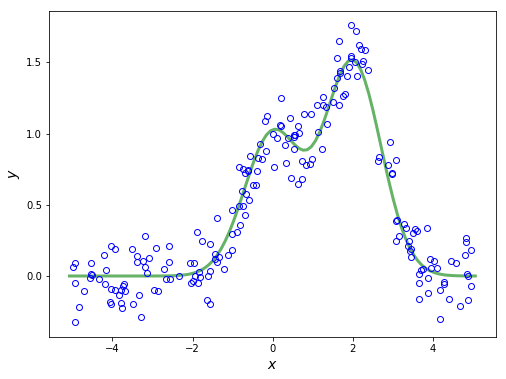

In [3]:
X_train, y_train, X_test, y_test, f_truth= nonlin_data(300)
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train, f=f_truth)
plt.show()

## 梯度提升回归

In [28]:
from pylib.utils.functions_for_regression import plot_fitted_line
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from matplotlib.colors import ListedColormap
import numpy as np

In [40]:
class GradientBoostingRegressor(BaseEstimator, RegressorMixin):
    """
    梯度提升回归
    
    参数：
    -----
    n_estimators：基本学习器的数量
    learning_rate：学习率，也可看做收缩参数
    max_depth：限制树的最大深度
    min_sample_leaf：叶子节点所允许包含的最小样本数量
    random_state：随机状态。若指定为整数，则能做出可重复结果
    
    属性：
    y0：函数参数的初始值，为目标变量的平均值
    loss_history：记录历史损失值
    """
    def __init__(self, n_estimators=100, learning_rate=0.1,
                 max_depth=3, min_sample_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_sample_leaf = min_sample_leaf
        self.random_state = random_state
        
    def __l2_neg_gradient(self, y, y_pred):
        return y - y_pred
    
    def __squared_loss(self, y, y_pred):
        return np.sum((y - y_pred)**2) / len(y)
        
    def fit(self, X, y):
        self.base_learners = []
        self.y0 = np.mean(y)
        yim = np.repeat(self.y0, len(X))  
        self.loss_history = []
        for m in range(self.n_estimators):
            base_learner = DecisionTreeRegressor(max_depth=self.max_depth,
                                                 min_samples_leaf=self.min_sample_leaf,
                                                 random_state=self.random_state)
            neg_grad = self.__l2_neg_gradient(y, yim)
            base_learner.fit(X, neg_grad)
            yim += self.learning_rate * base_learner.predict(X)  # 更新函数参数
            self.base_learners.append(base_learner)
            loss = self.__squared_loss(y, yim)
            self.loss_history.append(loss)
            
        return self
    
    def predict(self, X):
        y_pred = np.repeat(self.y0, len(X))
        for learner in self.base_learners:
            y_pred += self.learning_rate * learner.predict(X)
        return y_pred

In [41]:
gbdt = GradientBoostingRegressor(random_state=42)
gbdt.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [42]:
y_pred = gbdt.predict(X_train)
train_err = mean_squared_error(y_train, y_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.008


In [43]:
y_pred = gbdt.predict(X_test)
test_err = mean_squared_error(y_test, y_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.029


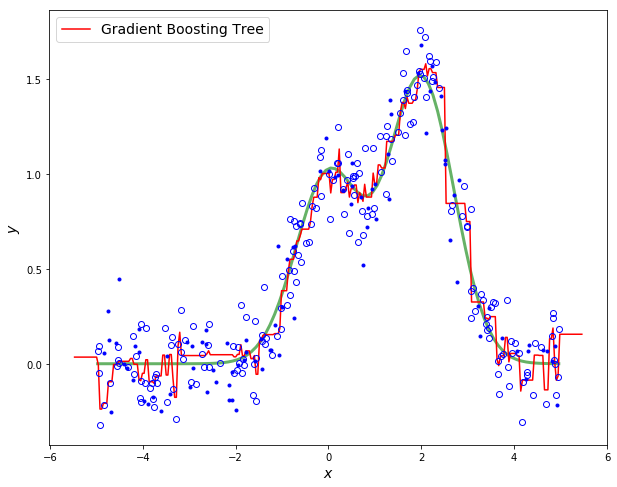

In [26]:
plt.figure(figsize=(10, 8))
plot_scatter(X_train, y_train, X_test, y_test, f=f_truth)
plot_fitted_line(gbdt, "Gradient Boosting Tree")
plt.show()

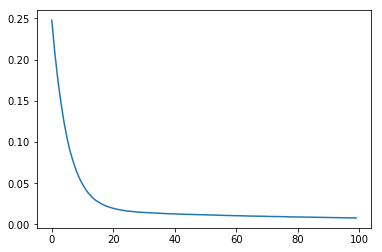

In [45]:
# 绘制历史损失值
loss_history = gbdt.loss_history
plt.plot(range(len(loss_history)), loss_history)
plt.show()

### 查看一系列学习器的决策边界

In [39]:
learners = gbdt.base_learners

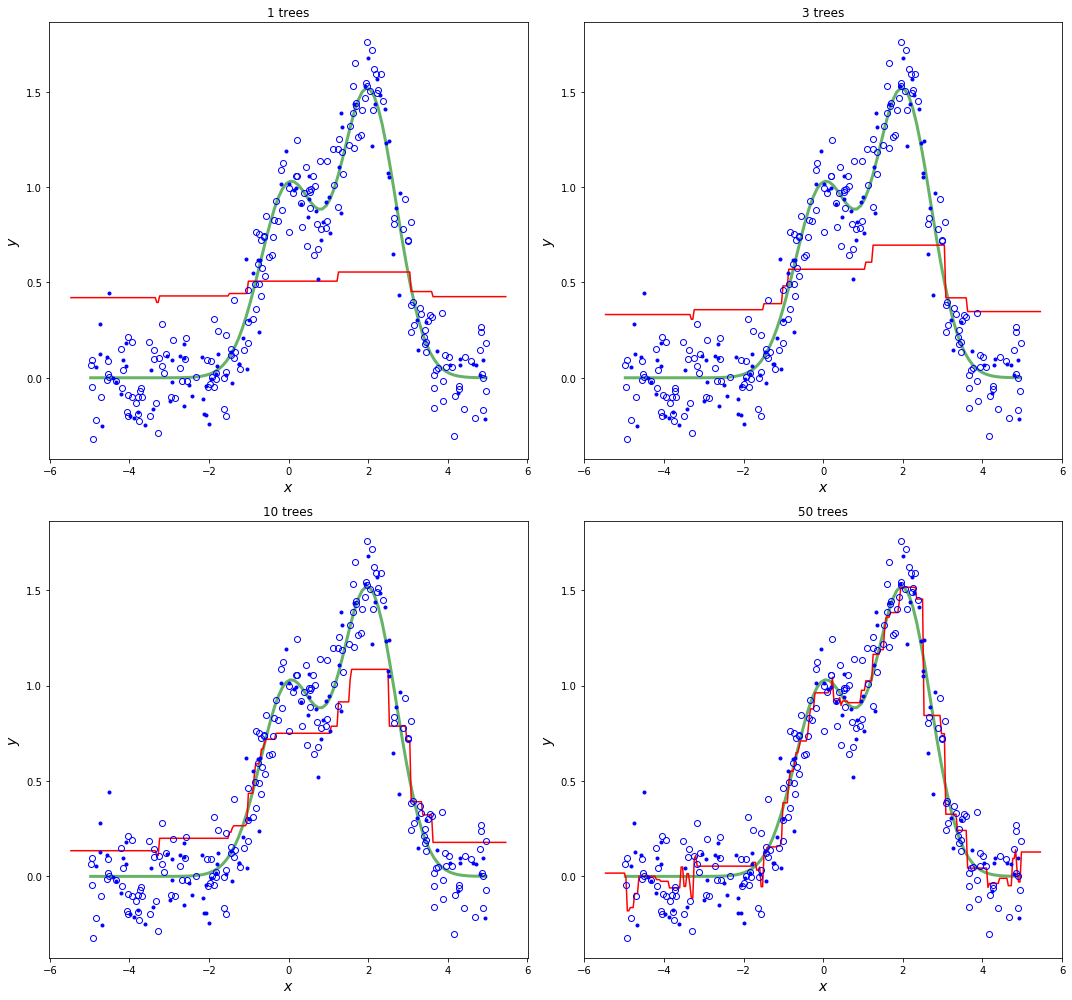

In [38]:
num = [1, 3, 10, 50]
plt.figure(figsize=(15, 14))
for i,j in enumerate(num):
    y_pred = gbdt.y0
    for learner in learners[:j]:
        y_pred += gbdt.learning_rate * learner.predict(xn)
    plt.subplot(int("22{}".format(i+1)))
    plot_scatter(X_train, y_train, X_test, y_test, f=f_truth)
    xn = np.linspace(plt.xlim()[0], plt.xlim()[1],300).reshape(-1, 1)
    plt.plot(xn, y_pred, c='r')
    plt.title("{} trees".format(j))
plt.tight_layout()
plt.show()